### The Libraries

the libraries that were included in the code in order to accomudate their functions

In [15]:
import glob as gb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import random

from keras_preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.callbacks import Callback
from keras.utils import to_categorical



from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import warnings

from IPython.display import Markdown, display



## Pre-defined functions

In [16]:
def load_images_files(fileorigin,onepath = False, label = ""):
# Load the paths to the images in a directory
# or load the images
    if onepath == False:
        images = []
        for filename in os.listdir(fileorigin):
            img = plt.imread(os.path.join(fileorigin,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(fileorigin):
            img_path = os.path.join(fileorigin,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path



#----------------------------------------------------------------------------

def cut_data_frame(df, nop, part):
    if part < 1:
        print("Error")

    elif part > nop:
        print("Error Part > nop")

    number_imgs_each_part = int(df.shape[0]/nop)
    idxI = (part - 1) * number_imgs_each_part
    idxII = part * number_imgs_each_part
    return df.iloc[idxI:idxII]

    #----------------------------------------------------------------------
def from_categorical(list):
    list = list.tolist()
    listII = []
    for x in list:
        listII.append(x.index(max(x)))
    return listII
    
    #----------------------------------------------------------------------
def printmd(string):
    display(Markdown(string))
    #----------------------------------------------------------------------
def stats_screening(y_test, preds):
    print(f"### Results of the prediction using {len(y_test)} test data ### \h")
    y_test_class = from_categorical(y_test)
    print("Classification Report:\n")
    print(classification_report(y_test_class, preds))
    print("\nConfusion MAtrix:\n\n")
    print(confusion_matrix(y_test, preds))
    print("\n")
    printmd(f"# Accuracy {round(accuracy_score(y_test_class, preds), 5)}")

## Data Set Location



In [17]:
path = "C:\\Users\\osama\iCloudDrive\\University\\UEMH4334- Machine Vision\\Practical\\Lab 2\\Gabage Classification"

images_list = gb.glob(os.path.join(path, '*/*.jpg'))

df = pd.DataFrame(images_list, columns= ["images"])

print("There about " + str(len(images_list)) + " in the folder combined")
df.head()

There about 1173 in the folder combined


,images
0,C:\Users\osama\iCloudDrive\University\UEMH4334...
1,C:\Users\osama\iCloudDrive\University\UEMH4334...
2,C:\Users\osama\iCloudDrive\University\UEMH4334...
3,C:\Users\osama\iCloudDrive\University\UEMH4334...
4,C:\Users\osama\iCloudDrive\University\UEMH4334...


for i, img_path in enumerate(random.sample(images_list, 25)):
    img = load_img(img_path)
    img = img_to_array(img, dtype = np.uint8)
    
    plt.subplot(5, 5, i+1)
    plt.imshow(img)


In [18]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range= 0.1,
    width_shift_range= 0.1,
    height_shift_range= 0.1,
    horizontal_flip= True,
    vertical_flip= True,
    validation_split= 0.1
)

test_datagen = ImageDataGenerator(
    rescale= 1./255,
    validation_split= 0.1
)

validation_generator = test_datagen.flow_from_directory(
    path,
    target_size= (300, 300),
    batch_size= 16,
    class_mode= 'categorical',
    subset= 'validation',
    seed= 0
)

train_generator = train_datagen.flow_from_directory(
    path,
    target_size = (300, 300),
    batch_size = 16,
    class_mode = 'categorical',
    subset= 'training',
    seed= 0
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)




Found 115 images belonging to 6 classes.
Found 1058 images belonging to 6 classes.
{0: 'Cardboard', 1: 'General Waste', 2: 'Glass', 3: 'Metal', 4: 'Paper', 5: 'Plastic'}


## 5 Convolution Layers

In [19]:
model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(pool_size=2),


    Flatten(),
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])



## 2 Connected Layers

In [20]:
model.add(Dense(
    64,
    activation= 'relu'
)
)

model.add(Dense(
    6,
    activation= 'softmax'
))

## Model Summary 

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 150, 150, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 37, 37, 64)      

In [22]:
from keras.callbacks import Callback
Epochs = 20
class StoppingEarly(keras.callbacks.Callback):
    def StoppingByEpoch(gen_rev, Epochs, logs={}):
        if(logs.get('acc') > 0.90):
            gen_rev.model.stop_training = True

call_back = StoppingEarly()

In [23]:
history = model.fit_generator(
    train_generator,
    epochs= Epochs,     
    callbacks= [call_back],
    validation_data=validation_generator

)

67/67 [==============================] - 145s 2s/step - loss: 1.6785 - acc: 0.2127 - val_loss: 1.6179 - val_acc: 0.2522


In [25]:
history = model.fit_generator(
    train_generator,
    epochs= Epochs,     
    callbacks= [call_back],
    validation_data=validation_generator

)

67/67 [==============================] - 111s 2s/step - loss: 1.6112 - acc: 0.2977 - val_loss: 1.5422 - val_acc: 0.3478


In [42]:
float_lst = []
for item in history.history['acc']:
    float_lst.append(float(item))
print("The accuracy is ")
print(float_lst)

[0.29773157835006714]


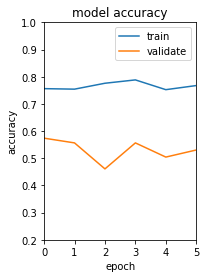

In [ ]:


plt.subplot(1,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylim([0.2,1])
plt.xlim([0,20])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validate'],loc='upper right')

plt.show()

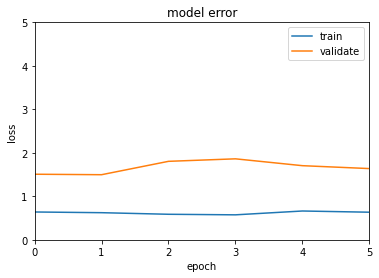

In [ ]:

plt.subplot(1,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0,5])
plt.xlim([0, 20])
plt.title('model error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validate'],loc='upper right')

plt.show()

In [ ]:
file = os.listdir(path)
images = os.listdir(path + "\\")
for f in file:
    print('\n')
    print(f)

    images = os.listdir(path + "\\" + f)
    for i in images:
        print(i)
    



Cardboard
Cardboard (1).jpg
Cardboard (10).jpg
Cardboard (100).jpg
Cardboard (101).jpg
Cardboard (102).jpg
Cardboard (103).jpg
Cardboard (104).jpg
Cardboard (105).jpg
Cardboard (106).jpg
Cardboard (107).jpg
Cardboard (108).jpg
Cardboard (109).jpg
Cardboard (11).jpg
Cardboard (110).jpg
Cardboard (111).jpg
Cardboard (112).jpg
Cardboard (113).jpg
Cardboard (114).jpg
Cardboard (115).jpg
Cardboard (116).jpg
Cardboard (117).jpg
Cardboard (118).jpg
Cardboard (119).jpg
Cardboard (12).jpg
Cardboard (120).jpg
Cardboard (121).jpg
Cardboard (122).jpg
Cardboard (123).jpg
Cardboard (124).jpg
Cardboard (125).jpg
Cardboard (126).jpg
Cardboard (127).jpg
Cardboard (128).jpg
Cardboard (129).jpg
Cardboard (13).jpg
Cardboard (130).jpg
Cardboard (131).jpg
Cardboard (132).jpg
Cardboard (133).jpg
Cardboard (134).jpg
Cardboard (135).jpg
Cardboard (136).jpg
Cardboard (137).jpg
Cardboard (138).jpg
Cardboard (139).jpg
Cardboard (14).jpg
Cardboard (140).jpg
Cardboard (141).jpg
Cardboard (142).jpg
Cardboard (143)

In [ ]:
test_x, test_y = validation_generator.__getitem__(1)

preds = model.predict(test_x)

plt.figure(figsize=(25, 25))
for i in range(50):
    plt.subplot(10, 5, i+1)
    plt.title('pred:%s / truth:%s' % (labels[argmax(preds[i])], labels[argmax(test_y[i])]))
    plt.imshow(test_x[i])






1/1 [==============================] - 0s 390ms/step


<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

In [ ]:
%%time

data = pd.DataFrame()
for class_ in os.listdir(path + "\\"):
    temp = pd.DataFrame()
    temp['path'] = np.nan
    temp['target'] = class_
    i = 0

    for photo in os.listdir(path + "\\" + class_):
        temp.loc[i, 'path'] = path + "\\" + class_ + "\\" + photo
        temp.loc[i, 'target'] = class_
        i += 1

    data = pd.concat([data, temp], ignore_index= True)
    del temp 

data.shape

data = data.sample(frac = 1)
data.reset_index(drop= True, inplace= True)


CPU times: total: 281 ms
Wall time: 300 ms


c:\Users\osama\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Glass'),
  Text(1, 0, 'Plastic'),
  Text(2, 0, 'General Waste'),
  Text(3, 0, 'Cardboard'),
  Text(4, 0, 'Paper'),
  Text(5, 0, 'Metal')])

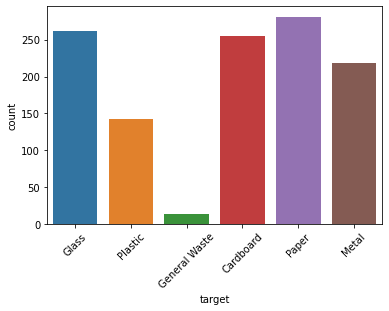

In [ ]:


sns.countplot(data['target'])
plt.xticks(rotation="45")

In [ ]:
import warnings
warnings.filterwarnings("ignore")


stats_screening(test_y, preds)
y = load_img(cut_data_frame(df, 20, 20))
preds = model.predict(test_x)
test_y = to_categorical(y)


stats_screening(test_y, preds)

NameError: name 'test_y' is not defined